# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>3 |</span></b> <b>LOAD LIBARIES</b></div>

In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
VER = 1

In [2]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

USE_WAVELET = None

# DENOISE FUNCTION
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret
import librosa

def spectrogram_from_eeg(parquet_path, display=False):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')
    
    # Parameters for STFT
    sr = 200  # Sample rate
    n_fft = 1024  # Number of FFT points
    max_bin = int(20 * n_fft / sr)  # Limit for frequency bins (20 Hz)

    if display: plt.figure(figsize=(10,7))
    signals = []
    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
        
            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # DENOISE
            if USE_WAVELET:
                x = denoise(x, wavelet=USE_WAVELET)
            signals.append(x)
            
            # STFT SPECTROGRAM (From the raw EEG data, limiting frequency to 0-20Hz)
            D = librosa.stft(y=x, n_fft=n_fft, hop_length=len(x)//256, win_length=128)
            width = (D.shape[1]//32)*32
            spectrogram = np.abs(D)[:max_bin + 1, :]
            spectrogram_db = librosa.power_to_db(spectrogram)
            
            freqs = np.linspace(0, 20, spectrogram_db.shape[0])
            target_freqs = np.linspace(0, 20, 128)
            
            rescaled_spectrogram = np.zeros((128, spectrogram_db.shape[1]))
            for i in range(spectrogram_db.shape[1]):
                rescaled_spectrogram[:, i] = np.interp(target_freqs, freqs, spectrogram_db[:, i])
            if (rescaled_spectrogram.shape != (128, 257)):
                print("rescaled_spectrogram: ", rescaled_spectrogram.shape)
            # STANDARDIZE TO -1 TO 1    
            rescaled_spectrogram = normalize(rescaled_spectrogram)

            img[:,:,k] += rescaled_spectrogram[:, :width]
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
        
        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Spectrogram {NAMES[k]}')
            
    if display: 
        plt.show()
        plt.figure(figsize=(10,5))
        offset = 0
        for k in range(4):
            if k>0: offset -= signals[3-k].min()
            plt.plot(range(10_000),signals[k]+offset,label=NAMES[3-k])
            offset += signals[3-k].max()
        plt.legend()
        plt.title(f'EEG {eeg_id} Signals')
        plt.show()
        print(); print('#'*25); print()
        
    return img

def normalize(arr):
    """Normalizes numpy arrays within the range -1 and 1"""
    if (np.min(arr) == np.max(arr)):
        print("happens")
        normalized_arr = np.zeros(arr.shape)
    else:
        normalized_arr = 2 * ((arr - np.min(arr)) / (np.max(arr) - np.min(arr))) - 1
    return normalized_arr

In [3]:
# check the reading of one parquet for understanding

BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'

df = pd.DataFrame({'path': glob(BASE_PATH + '**/*.parquet')})
df['test_type'] = df['path'].str.split('/').str.get(-2).str.split('_').str.get(-1)
df['id'] = df['path'].str.split('/').str.get(-1).str.split('.').str.get(0)

df_eeg = pd.read_parquet(BASE_PATH + 'train_eegs/1000913311.parquet')
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [4]:
# Determine the number of channels
# Assuming each row is a time point and each column is a channel
n_channels = df_eeg.shape[1]
n_channels

20

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>5 |</span></b> <b>LOAD TRAIN DATA</b></div>

In [5]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>6 |</span></b> <b>CREATE NON-OVERLAPPING EEG ID TRAIN DATA</b></div>

Following the notebook from Chris Deotte: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-8,
Initial discussion found here https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

We perform the following because:

* **Match Training Data with Test Data Format:** The competition states that the test data does not have multiple segments from the same eeg_id. To make the training data similar to the test data, we also use only one segment per eeg_id in the training data.

* **Remove Redundancies:** This approach ensures that the training data does not have overlapping or redundant information, which can lead to a more accurate and generalizable machine learning model.

* **Consistency in Data:** By standardizing how we handle the EEG segments in training, we ensure that our model learns from data that is consistent in format with the data it will be tested on.

* **Data Preparation for Machine Learning:** The normalization of target variables and inclusion of relevant features like patient_id and expert_consensus prepare the dataset for effective machine learning modeling.

In [6]:
# Creating a Unique EEG Segment per eeg_id:
# The code groups (groupby) the EEG data (df) by eeg_id. Each eeg_id represents a different EEG recording.
# It then picks the first spectrogram_id and the earliest (min) spectrogram_label_offset_seconds for each eeg_id. This helps in identifying the starting point of each EEG segment.
# The resulting DataFrame train has columns spec_id (first spectrogram_id) and min (earliest spectrogram_label_offset_seconds).
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']


# Finding the Latest Point in Each EEG Segment:
# The code again groups the data by eeg_id and finds the latest (max) spectrogram_label_offset_seconds for each segment.
# This max value is added to the train DataFrame, representing the end point of each EEG segment.
tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp


tmp = df.groupby('eeg_id')[['patient_id']].agg('first') # The code adds the patient_id for each eeg_id to the train DataFrame. This links each EEG segment to a specific patient.
train['patient_id'] = tmp


tmp = df.groupby('eeg_id')[TARGETS].agg('sum') # The code sums up the target variable counts (like votes for seizure, LPD, etc.) for each eeg_id.
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values # It then normalizes these counts so that they sum up to 1. This step converts the counts into probabilities, which is a common practice in classification tasks.
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first') # For each eeg_id, the code includes the expert_consensus on the EEG segment's classification.
train['target'] = tmp

train = train.reset_index() # This makes eeg_id a regular column, making the DataFrame easier to work with.
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [7]:
train[(train.spec_id == 1908433744) & (train['min'] // 1000 == 2)]

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
564,147350182,1908433744,2615.0,2615.0,17408,0.0,0.0,1.0,0.0,0.0,0.0,GPD
16281,4084934272,1908433744,2063.0,2063.0,17408,0.0,0.0,1.0,0.0,0.0,0.0,GPD
16954,4255016832,1908433744,2783.0,2783.0,17408,0.0,0.0,1.0,0.0,0.0,0.0,GPD
17060,4285210475,1908433744,2845.0,2845.0,17408,0.0,0.0,1.0,0.0,0.0,0.0,GPD


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>7 |</span></b> <b>FEATURE ENGINEERING</b></div>



<b><span style='color:#FFCE30'> 7.1 |</span> 10 min and 20 sec windows</b>

* The code belows efficiently reads spectrogram data, from a single combined file, based on the set variable. We relied on the dataset by Chris Deotte to save time. https://www.kaggle.com/datasets/cdeotte/brain-spectrograms
* It then performs feature engineering by calculating mean and minimum values over two different time windows for each frequency in the spectrogram.
It produce produces in 1600 features (400 features × 4 calculations) for each EEG ID.
* The new features are intended to help the model better understand and classify the EEG data.
* This approach is designed to enhance the model's performance by providing it with more detailed information derived from the spectrogram data.

In [8]:
READ_SPEC_FILES = False # If READ_SPEC_FILES is False, the code reads the combined file instead of individual files.
FEATURE_ENGINEER = True
READ_EEG_SPEC_FILES = False

In [9]:
%%time
# READ ALL SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load("/kaggle/input/stft-spectrograms-from-eeg/eeg_specs.npy",allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 4.05 s, sys: 7.98 s, total: 12 s
Wall time: 1min 40s


In [10]:
print('original shape: ', spectrograms[1000913311].shape)

for i, key in enumerate(spectrograms):
    layer0 = spectrograms[key][:,:,0]
    layer1 = spectrograms[key][:,:,1]
    layer2 = spectrograms[key][:,:,2]
    layer3 = spectrograms[key][:,:,3]
    
    spectrograms[key] = np.vstack([layer0, layer1, layer2, layer3])

print('new shape: ', spectrograms[1000913311].shape)

original shape:  (128, 256, 4)
new shape:  (512, 256)


# Autoencoder Definition

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
numFeatures20sec = 1600
numFeatures50sec = 2000
# Define the autoencoder architecture
class Autoencoder2D(nn.Module):
    def __init__(self):
        super(Autoencoder2D, self).__init__()
        #Where is this input layer?
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4096, numFeatures50sec),
            nn.ReLU(),
            
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(numFeatures50sec, 4096),
            nn.ReLU(),
            nn.Unflatten(1, (8, 32, 16)),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1),
            nn.ReLU(), 
            nn.ConvTranspose2d(16, 32, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
#Potentially decrease size of encoded data 
#Convolutional 2D takes in only 2d data, we have 3d data here!
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
 
# Define the autoencoder architecture
class Autoencoder20second2D(nn.Module):
    def __init__(self):
        super(Autoencoder20second2D, self).__init__()
        #What to replace the batch size (in channels) parameter with?
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding= 1), #For detecting features
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(3072, numFeatures20sec),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(numFeatures20sec, 3072),
            nn.ReLU(),
            nn.Unflatten(1, (4, 64, 12)),
            nn.ConvTranspose2d(4, 8, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(8, 32, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(32, 1, 
                               kernel_size=3, 
                               stride=2,
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.pad(x, (0, 6, 0, 0), mode='constant', value=0) 
        return x

# Autoencoder Feature Engineering - Spectrogram Level

In [13]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')
SPEC_FREQS = len(pd.read_parquet(f'{PATH}1000086677.parquet').columns[1:])
print(f"Num Frequencies: {SPEC_FREQS}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # delete when issue resolved
print("Using: ", device)
"""
Define 50sec feature autoencoder
"""
model_50sec = Autoencoder2D()
model_50sec = model_50sec.to(device)
loss_function_50sec = torch.nn.MSELoss()
optimizer_50sec = torch.optim.Adam(model_50sec.parameters(),
                            lr = 1e-4,
                            )

"""
Define 20sec feature autoencoder
"""
#model_20sec = ConvAutoencoder(SPEC_FREQS, 400, numFeatures)
model_20sec = Autoencoder20second2D()
model_20sec = model_20sec.to(device)
loss_function_20sec = torch.nn.MSELoss()
optimizer_20sec = torch.optim.Adam(model_20sec.parameters(),
                            lr = 1e-4,
                            )

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 9.3 µs
Num Frequencies: 400
Using:  cuda


In [14]:
""" For 2D Convolutional Autoencoder 
Does stochastic gradient descent on the entire dataset
"""
%timeit
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer

# Create a SimpleImputer instance
nan_imputer = SimpleImputer(strategy='mean')

batch_size = 10
print(f"Training Autoencoder on {len(train)} datapoints with batch size {batch_size}")
num_epochs = 8 # fine with 2-3 epochs but should do more with GPU if possible
log_noise = 1
for epoch in range(num_epochs): 
    num_batches = len(train) // batch_size + 1
    epoch_loss_50sec = 0.0
    epoch_loss_20sec = 0.0
    print(f"Batches {num_batches}:", end=' ')
    
    for i in range(num_batches):        
        
        row_start = i * batch_size #Currently, it is i
        row_end = min((i + 1) * batch_size, len(train)) #Currently, it is (i+1)
        
        input_50sec_list = []
        input_20sec_list = []
        
        for k in range(row_start, row_end):
            row = train.iloc[k]
            r = int((row['min'] + row['max']) // 4)

            # get raw spectrogram values
            raw_values_50sec = spectrograms[row.eeg_id]
            raw_values_20sec = spectrograms[row.eeg_id][:,77:179]

            # Replace infinite values
            raw_values_50sec = np.where(np.isfinite(raw_values_50sec), raw_values_50sec, np.nan)
            raw_values_20sec = np.where(np.isfinite(raw_values_20sec), raw_values_20sec, np.nan)            
            
            # Use SimpleImputer to handle NaN values
            raw_values_50sec = nan_imputer.fit_transform(raw_values_50sec)
            raw_values_20sec = nan_imputer.fit_transform(raw_values_20sec)
            
            raw_values_50sec[~np.isfinite(raw_values_50sec) | (raw_values_50sec < 0)] = 0
            raw_values_20sec[~np.isfinite(raw_values_20sec) | (raw_values_20sec < 0)] = 0
            
            #Convert to torch tensors and append to the lists
            if len(raw_values_50sec.flatten()) == 512 * 256:
                raw_values_50sec = np.log(raw_values_50sec + log_noise)
                if raw_values_50sec.max() != raw_values_50sec.min():
                    normalized_values_50sec = (raw_values_50sec - raw_values_50sec.min()) / (raw_values_50sec.max() - raw_values_50sec.min())
                    input_50sec_list.append(normalized_values_50sec)
            else:
                print("invalid shape", len(raw_values_50sec.flatten()))
                
            if len(raw_values_20sec.flatten()) == 512 * 102:
                # normalize
                raw_values_20sec = np.log(raw_values_20sec + log_noise)
                if raw_values_20sec.max() != raw_values_20sec.min():
                    normalized_values_20sec = (raw_values_20sec - raw_values_20sec.min()) / (raw_values_20sec.max() - raw_values_20sec.min())
                    input_20sec_list.append(normalized_values_20sec)
            else:
                print("invalid shape", len(raw_values_20sec.flatten()))
        
        # Forward pass through the autoencoders
        input_50sec_batch = torch.tensor(input_50sec_list, dtype=torch.float32).to(device)
        input_20sec_batch = torch.tensor(input_20sec_list, dtype=torch.float32).to(device)
        if input_50sec_batch.shape[0] != batch_size:
            input_50sec_batch = F.pad(input_50sec_batch, (0, 0, 0, 0, 0, batch_size-input_50sec_batch.shape[0]), mode='constant', value=0)
        
        if input_20sec_batch.shape[0] != batch_size:
            input_20sec_batch = F.pad(input_20sec_batch, (0, 0, 0, 0, 0, batch_size-input_20sec_batch.shape[0]), mode='constant', value=0)
        
        output_50sec_batch = model_50sec(input_50sec_batch)
        output_20sec_batch = model_20sec(input_20sec_batch)
        
        # Calculate loss and perform optimization for 50sec autoencoder
        loss_50sec = loss_function_50sec(output_50sec_batch, input_50sec_batch)
        optimizer_50sec.zero_grad()
        loss_50sec.backward()
        optimizer_50sec.step()

        # Calculate loss and perform optimization for 20sec autoencoder
        #print(output_20sec_batch.shape, input_20sec_batch.shape)
        loss_20sec = loss_function_20sec(output_20sec_batch, input_20sec_batch)
        
        optimizer_20sec.zero_grad()
        loss_20sec.backward()
        optimizer_20sec.step()
        # Accumulate epoch loss
        epoch_loss_50sec += loss_50sec.item()
        epoch_loss_20sec += loss_20sec.item()

        # Clean up to avoid memory issues
        del output_50sec_batch, output_20sec_batch, input_50sec_batch, input_50sec_list, input_20sec_batch, input_20sec_list
        
        if i % 20 == 0:
            print(f"Done batch {i}, {epoch_loss_50sec}, {epoch_loss_20sec}", end = '... ')

    # Calculate average loss for the epoch
    avg_loss_50sec = epoch_loss_50sec / num_batches
    avg_loss_20sec = epoch_loss_20sec / num_batches

    print(f"Epoch {epoch} Summary: Avg Loss_50sec: {avg_loss_50sec}, Avg Loss_20sec: {avg_loss_20sec}")
    

Training Autoencoder on 17089 datapoints with batch size 10
Batches 1709: Done batch 0, 0.19731010496616364, 0.18885160982608795... Done batch 20, 3.8676326274871826, 3.6674648225307465... Done batch 40, 7.435833439230919, 7.004041895270348... Done batch 60, 11.077878251671791, 10.371421456336975... Done batch 80, 13.41727950796485, 13.196552582085133... Done batch 100, 14.267484497278929, 15.373672112822533... Done batch 120, 14.895901963114738, 16.852094169706106... Done batch 140, 15.454866860061884, 17.850863475352526... Done batch 160, 16.140422742813826, 18.8680734410882... Done batch 180, 16.74443420767784, 19.791219521313906... Done batch 200, 17.286133060231805, 20.59657495841384... Done batch 220, 17.86988953128457, 21.441117545589805... Done batch 240, 18.483010893687606, 22.282957216724753... Done batch 260, 19.05619685165584, 23.107782155275345... Done batch 280, 19.649626657366753, 23.939786564558744... Done batch 300, 20.211694424971938, 24.74016959965229... Done batch 3

In [15]:
%timeit
"""
Get Feature Data 
#We need 4000 features from here to fit into the XGBoost 
Takes about an hour to run
"""
numFeatures_50sec = 2000
numFeatures_20sec = 1600
totalFeatures = numFeatures_50sec + numFeatures_20sec
#change all the 
print(f"Generating {totalFeatures} features on {len(train)} datapoints")
FEATURES = ["feature_{}_50sec".format(i) for i in range(numFeatures_50sec)]
FEATURES += ["feature_{}_20sec".format(i) for i in range(numFeatures_20sec)]
data = np.zeros((len(train), len(FEATURES)))

for k in range(len(train)):
    #It is going individual, to make it work for a higher batch size, fix this!!
    if k%100==0: print(k,', ',end='')
    row = train.iloc[k]
    r = int( (row['min'] + row['max'])//4 ) 
    

# 10 MINUTE WINDOW FEATURES
    # this will likey need to be unsqueezed or smth
    raw_data = spectrograms[row.eeg_id]
    raw_data = np.where(np.isfinite(raw_data), raw_data, np.nan)
    raw_data = nan_imputer.fit_transform(raw_data)
    raw_data[~np.isfinite(raw_data) | (raw_data < 0)] = 0
    
    raw_data = np.log(raw_data + log_noise)
    if raw_data.max() != raw_data.min():
        x = (raw_data - raw_data.min()) / (raw_data.max() - raw_data.min())
    else:
        x = np.zeros(raw_data.shape)
    x = x.reshape((1, 1, x.shape[0], x.shape[1]))
    x = np.array(model_50sec.encoder(torch.tensor(x, dtype=torch.float32).to(device)).tolist())
    data[k,:numFeatures_50sec] = x.flatten() #Can we remove this flattnening?

    # 20 SECOND WINDOW FEATURES 
    # this will likey need to be unsqueezed or smth
    raw_data = spectrograms[row.eeg_id][:,77:179]
    raw_data = np.where(np.isfinite(raw_data), raw_data, np.nan)
    raw_data = nan_imputer.fit_transform(raw_data)
    raw_data[~np.isfinite(raw_data) | (raw_data < 0)] = 0
    
    raw_data = np.log(raw_data + log_noise)
    if raw_data.max() != raw_data.min():
        x = (raw_data - raw_data.min()) / (raw_data.max() - raw_data.min())
    else:
        x = np.zeros(raw_data.shape)
    x = x.reshape((1, 1, x.shape[0], x.shape[1]))
    x = np.array(model_20sec.encoder(torch.tensor(x, dtype=torch.float32).to(device)).tolist())
    data[k,numFeatures_50sec:numFeatures_50sec+numFeatures_20sec] = x.flatten()
    if k%100==0: print("Done {}".format(k))
print(data.shape)
train[FEATURES] = data #Fails on this memory allocation,we would need to reduce the dimensions of the 10 min data. 
print('New train shape:',train.shape)

Generating 3600 features on 17089 datapoints
0 , Done 0
100 , Done 100
200 , Done 200
300 , Done 300
400 , Done 400
500 , Done 500
600 , Done 600
700 , Done 700
800 , Done 800
900 , Done 900
1000 , Done 1000
1100 , Done 1100
1200 , Done 1200
1300 , Done 1300
1400 , Done 1400
1500 , Done 1500
1600 , Done 1600
1700 , Done 1700
1800 , Done 1800
1900 , Done 1900
2000 , Done 2000
2100 , Done 2100
2200 , Done 2200
2300 , Done 2300
2400 , Done 2400
2500 , Done 2500
2600 , Done 2600
2700 , Done 2700
2800 , Done 2800
2900 , Done 2900
3000 , Done 3000
3100 , Done 3100
3200 , Done 3200
3300 , Done 3300
3400 , Done 3400
3500 , Done 3500
3600 , Done 3600
3700 , Done 3700
3800 , Done 3800
3900 , Done 3900
4000 , Done 4000
4100 , Done 4100
4200 , Done 4200
4300 , Done 4300
4400 , Done 4400
4500 , Done 4500
4600 , Done 4600
4700 , Done 4700
4800 , Done 4800
4900 , Done 4900
5000 , Done 5000
5100 , Done 5100
5200 , Done 5200
5300 , Done 5300
5400 , Done 5400
5500 , Done 5500
5600 , Done 5600
5700 , Don

In [16]:
### To prevent running the encoder part again
# train[FEATURES] = data

# print('New train shape:',train.shape)


In [17]:
print(data.shape)

(17089, 3600)


<b><span style='color:#FFCE30'> 7.2 |</span>  Frequency Band Analysis</b>

#### Frequency Band Feature Extraction:

* The function extract_frequency_band_features is designed to process a segment of EEG data. EEG data is a complex signal that represents the electrical activity of the brain.
* This function divides the EEG signal into different frequency bands: Delta, Theta, Alpha, Beta, and Gamma. These bands are significant in neuroscientific studies as they are associated with different brain states and activities.

![](https://ars.els-cdn.com/content/image/3-s2.0-B9780128044902000026-f02-01-9780128044902.jpg)


1. **Delta (0.5 – 4 Hz):**
Delta waves are the slowest brainwaves and are typically associated with deep sleep and restorative processes in the body. They are most prominent during dreamless sleep and play a role in healing and regeneration.
2. **Theta (4 – 8 Hz):**
Theta waves occur during light sleep, deep meditation, and REM (Rapid Eye Movement) sleep. They are linked to creativity, intuition, daydreaming, and fantasizing. Theta states are often associated with subconscious mind activities.
3. **Alpha (8 – 12 Hz):**
Alpha waves are present during physically and mentally relaxed states but still alert. They are typical in wakeful states that involve a relaxed and effortless alertness. Alpha waves aid in mental coordination, calmness, alertness, and learning.
4. **Beta (12 – 30 Hz):**
Beta waves dominate our normal waking state of consciousness when attention is directed towards cognitive tasks and the outside world. They are associated with active, busy or anxious thinking and active concentration.
5. **Gamma (30 – 45 Hz):**
Gamma waves are involved in higher mental activity and consolidation of information. They are important for learning, memory, and information processing. Gamma waves are thought to be the fastest brainwave frequency and relate to simultaneous processing of information from different brain areas.




* For each frequency band, the function applies a bandpass filter to isolate that band's signal. It then computes statistical features (mean, standard deviation, maximum, and minimum) for each band, effectively capturing the characteristics of the EEG signal in these different frequency ranges.
* The use of np.nanmean, np.nanstd, np.nanmax, and np.nanmin ensures that the calculations are robust to NaN (Not a Number) values in the data, which might occur due to various reasons like signal loss or artifacts.

#### Feature Aggregation and PCA:

* The main script initializes a Principal Component Analysis (PCA) model with the intention of reducing the dimensionality of the extracted features. PCA is a common technique used to transform high-dimensional datasets into a lower-dimensional space while retaining most of the variance in the data.
* The script iterates over rows in the train dataset, extracting EEG segments and applying the extract_frequency_band_features function to each channel in these segments. The extracted features from all channels are aggregated.
* However, before applying PCA, any NaN values in the aggregated data (data_original) are handled using mean imputation. This step ensures that the PCA algorithm, which cannot handle NaN values, receives a clean dataset.
* After imputation, PCA is applied to transform the features into a principal component space, and these transformed features are added back into the train DataFrame.
* This process ultimately results in a feature set that's potentially more informative and concise for machine learning models, helping in tasks like classification or anomaly detection in EEG data.

In [18]:
# print("Introduced band-level features of: ", len(train.columns) - len(FEATURES) - 12)
# print(pca_feature_columns)
# FEATURES += pca_feature_columns
# train.head()

In [19]:
#Scaling the feature values --> scale the features to have a mean of 0 and a standard deviation of 1.
from sklearn.preprocessing import StandardScaler

# Columns to be excluded from scaling
excluded_columns = ['eeg_id', 'spec_id', 'min', 'max', 'patient_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote','target']

# Save the columns to be excluded
excluded_data = train[excluded_columns]

# DataFrame with only the columns to be scaled
features = train.drop(columns=excluded_columns)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the features and transform them
features_scaled = scaler.fit_transform(features)

# Create a DataFrame from the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Concatenate the scaled features with the excluded columns
train_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
# train_scaled_df.to_csv("/kaggle/working/")
train_scaled_df 


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,feature_1590_20sec,feature_1591_20sec,feature_1592_20sec,feature_1593_20sec,feature_1594_20sec,feature_1595_20sec,feature_1596_20sec,feature_1597_20sec,feature_1598_20sec,feature_1599_20sec
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,1.218159,-0.244893,0.0,0.0,0.0,0.0,-0.165222,0.0,-0.312354,0.0
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,-0.788136,0.995486,0.0,0.0,0.0,0.0,0.946257,0.0,0.956401,0.0
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.690122,0.162031,0.0,0.0,0.0,0.0,0.202419,0.0,0.157946,0.0
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,1.771660,-1.151160,0.0,0.0,0.0,0.0,-1.090331,0.0,-1.093455,0.0
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,1.447745,-0.397617,0.0,0.0,0.0,0.0,-0.294516,0.0,-0.352798,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,...,0.450129,0.186156,0.0,0.0,0.0,0.0,0.218220,0.0,0.113966,0.0
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,...,-1.135229,0.892129,0.0,0.0,0.0,0.0,0.938445,0.0,1.059821,0.0
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,...,-0.265586,-0.023554,0.0,0.0,0.0,0.0,-0.044168,0.0,0.015920,0.0
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,...,-1.310898,1.227005,0.0,0.0,0.0,0.0,1.206317,0.0,1.262024,0.0


In [20]:
train_scaled_df.describe()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,feature_1590_20sec,feature_1591_20sec,feature_1592_20sec,feature_1593_20sec,feature_1594_20sec,feature_1595_20sec,feature_1596_20sec,feature_1597_20sec,feature_1598_20sec,feature_1599_20sec
count,1.708900e+04,1.708900e+04,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,17089.000000,...,1.708900e+04,1.708900e+04,17089.0,17089.0,17089.0,17089.0,1.708900e+04,17089.0,1.708900e+04,17089.0
mean,2.135226e+09,1.080640e+09,401.650711,431.761191,32839.981977,0.152810,0.142456,0.104062,0.065407,0.114851,...,-1.143421e-17,1.399132e-16,0.0,0.0,0.0,0.0,-2.155869e-16,0.0,-7.097527e-16,0.0
std,1.235712e+09,6.251739e+08,1226.839779,1232.863269,18351.751174,0.331563,0.295541,0.258825,0.187005,0.271425,...,1.000029e+00,1.000029e+00,0.0,0.0,0.0,0.0,1.000029e+00,0.0,1.000029e+00,0.0
min,5.686570e+05,3.537330e+05,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.021449e+00,-5.083083e+00,0.0,0.0,0.0,0.0,-5.195932e+00,0.0,-5.089041e+00,0.0
25%,1.062096e+09,5.396648e+08,0.000000,4.000000,17408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.889576e-01,-4.939903e-01,0.0,0.0,0.0,0.0,-4.697213e-01,0.0,-5.109392e-01,0.0
50%,2.123560e+09,1.073264e+09,0.000000,40.000000,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.519752e-02,1.156458e-01,0.0,0.0,0.0,0.0,1.288663e-01,0.0,9.556361e-02,0.0
75%,3.208261e+09,1.641428e+09,308.000000,346.000000,48272.000000,0.000000,0.068966,0.000000,0.000000,0.000000,...,8.045534e-01,7.031723e-01,0.0,0.0,0.0,0.0,6.906214e-01,0.0,6.998024e-01,0.0
max,4.294958e+09,2.147388e+09,17556.000000,17632.000000,65494.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.063879e+00,2.029648e+00,0.0,0.0,0.0,0.0,2.004577e+00,0.0,2.221598e+00,0.0


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>8 |</span></b> <b>TRAIN MODEL</b></div>

* Original work uses catboost, let's try with XGBoost in this version to see the difference in model performance.

In [21]:
import xgboost as xgb
from sklearn.svm import SVC
import gc
from sklearn.model_selection import KFold, GroupKFold
import pickle
from sklearn.multioutput import MultiOutputRegressor
from scipy.special import rel_entr

In [22]:
len(FEATURES)

3600

In [23]:
## Regressor
%timeit
all_oof = []
all_true = []
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
n_splits = 5 
gkf = GroupKFold(n_splits=5) #5
for i, (train_index, valid_index) in enumerate(gkf.split(train_scaled_df, train_scaled_df.target, train_scaled_df.patient_id)):   
    if i >= n_splits:
        continue
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # Instantiate the XGBRegressor model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.1) # uses MSE to predict probabilities

    model = MultiOutputRegressor(xgb_model) # since we have multiple outputs
    
#     model = SVC(probability=True)    
    LABEL_NAMES = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    # Prepare training and validation data
    X_train = train_scaled_df.loc[train_index, FEATURES]
    y_train = train_scaled_df.loc[train_index, LABEL_NAMES]
    X_valid = train_scaled_df.loc[valid_index, FEATURES]
    y_valid = train_scaled_df.loc[valid_index, LABEL_NAMES]
    model.fit(X_train, y_train, verbose=True,) 

    with open(f'XGBoost_f{i}.pkl', 'wb') as f:
        pickle.dump(model, f)

    y_pred = model.predict(X_valid)
    y_pred[y_pred < 0] = 0
    oof = y_pred / np.sum(y_pred, axis=1).reshape(-1,1) # ensure they sum to 1
    true = y_valid.values
    kl_divergence = np.mean(np.sum(true * (np.log(true + 1e-10) - np.log(oof + 1e-10)), axis=1))
    print(f"Kale Divergence: {kl_divergence}")
    
    all_oof.append(oof)
    all_true.append(true)
    
    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.2415469266400658
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.222441387597497
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.098389479734588
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
Kale Divergence: 1.1339373969845976
#########################
### Fold 5
### train size 13672, valid size 3417
#########################
Kale Divergence: 1.1851203925128901


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>11 |</span></b> <b>INFER TEST</b></div>

In [24]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


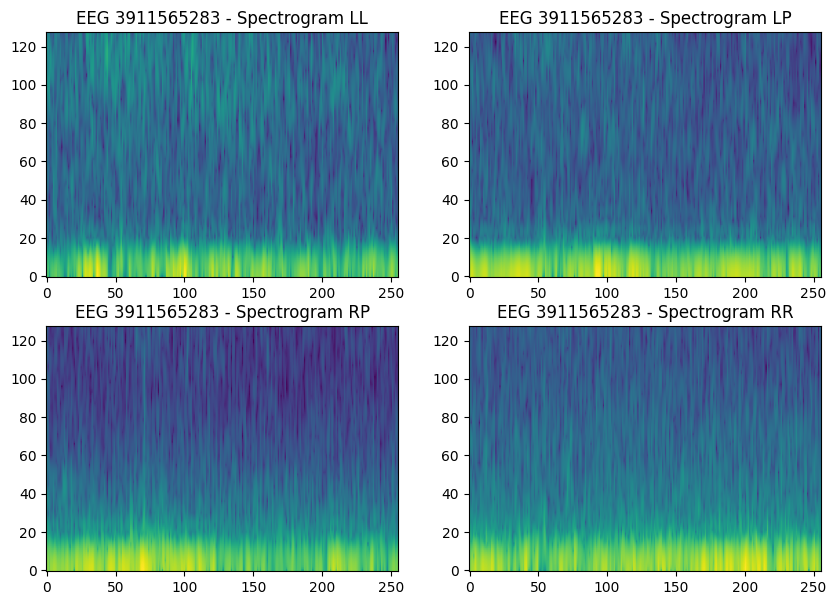

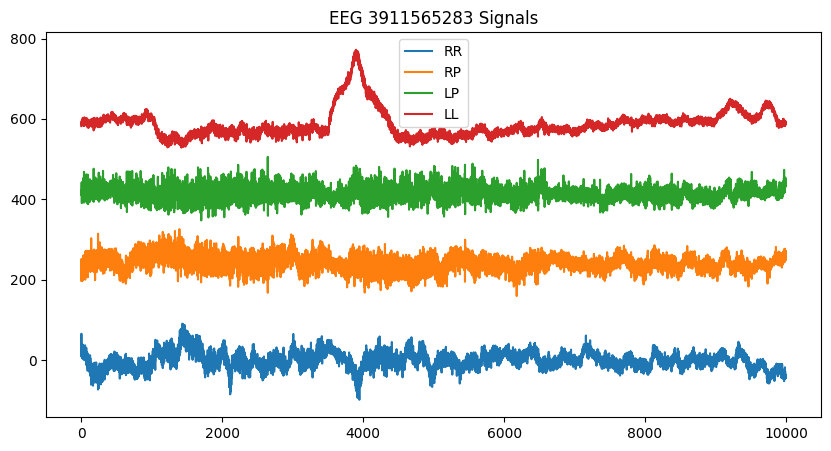


#########################

CPU times: user 8.82 s, sys: 546 ms, total: 9.37 s
Wall time: 9.55 s


In [25]:
%%time
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
DISPLAY = 4
EEG_IDS = test.eeg_id.unique()
all_eegs = {}

for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='')
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH}{eeg_id}.parquet', i<DISPLAY)
    
    # SAVE TO DISK
    if i==DISPLAY:
        print(f'Creating and writing {len(EEG_IDS)} spectrograms to disk... ',end='')

    all_eegs[eeg_id] = img

for i, key in enumerate(all_eegs):
    layer0 = all_eegs[key][:,:,0]
    layer1 = all_eegs[key][:,:,1]
    layer2 = all_eegs[key][:,:,2]
    layer3 = all_eegs[key][:,:,3]
    
    all_eegs[key] = np.vstack([layer0, layer1, layer2, layer3])

In [26]:
%time
# ENGINEER FEATURES
import warnings
warnings.filterwarnings('ignore')

TEST_FEATURES = FEATURES

print(f'We are creating {len(TEST_FEATURES)} features for {len(test)} rows... ',end='')


# A data matrix data is initialized to store the new features for each eeg_id in the train DataFrame.
# For each row in train, the code calculates the mean and minimum values within the specified 10-minute and 20-second windows.
# These calculated values are then stored in the data matrix.
# Finally, the matrix is added to the train DataFrame as new columns.

data_test = np.zeros((len(test),len(TEST_FEATURES)))
for k in range(len(test)):
    if k%100==0: print(k,', ',end='')
    row = test.iloc[k]       
    
    raw_data = all_eegs[row.eeg_id]
    raw_data = np.where(np.isfinite(raw_data), raw_data, np.nan)
    raw_data = nan_imputer.fit_transform(raw_data)
    raw_data[~np.isfinite(raw_data) | (raw_data < 0)] = 0
    
    raw_values_50sec = np.log(raw_data + log_noise)
    if raw_values_50sec.max() != raw_values_50sec.min():
        x = (raw_values_50sec - raw_values_50sec.min()) / (raw_values_50sec.max() - raw_values_50sec.min())
    else:
        x = np.zeros(raw_values_50sec.shape)
    x = x.reshape((1, 1, x.shape[0], x.shape[1]))
    x = np.array(model_50sec.encoder(torch.tensor(x, dtype=torch.float32).to(device)).tolist())   
    data_test[k,:numFeatures_50sec] = x.flatten()

    # 20 SECOND WINDOW FEATURES 
    raw_data = all_eegs[row.eeg_id][:,77:179]
    raw_data = np.where(np.isfinite(raw_data), raw_data, np.nan)
    raw_data = nan_imputer.fit_transform(raw_data)
    raw_data[~np.isfinite(raw_data) | (raw_data < 0)] = 0
    
    raw_values_20sec = np.log(raw_data + log_noise)
    if raw_values_20sec.max() != raw_values_20sec.min():
        x = (raw_values_20sec - raw_values_20sec.min()) / (raw_values_20sec.max() - raw_values_20sec.min())
    else:
        x = np.zeros(raw_values_50sec.shape)
    x = x.reshape((1, 1, x.shape[0], x.shape[1]))
    x = np.array(model_20sec.encoder(torch.tensor(x, dtype=torch.float32).to(device)).tolist())  
    data_test[k,numFeatures_50sec:numFeatures_50sec+numFeatures_20sec] = x.flatten()

print(len(TEST_FEATURES), data_test.shape)
test[TEST_FEATURES] = data_test

    

print('New test shape:',test.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
We are creating 3600 features for 1 rows... 0 , 3600 (1, 3600)
New test shape: (1, 3603)


In [27]:

# Columns to be excluded from scaling
excluded_columns = ['eeg_id', 'spectrogram_id', 'patient_id']

# Save the columns to be excluded
excluded_data = test[excluded_columns]

# DataFrame with only the columns to be scaled
features = test.drop(columns=excluded_columns)

# Initialize the StandardScaler
# scaler = StandardScaler()

# Fit the scaler to the features and transform them
features_scaled = scaler.transform(features)

# Create a DataFrame from the scaled features
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

# Concatenate the scaled features with the excluded columns
test_scaled_df = pd.concat([excluded_data.reset_index(drop=True),features_scaled_df,], axis=1)
test_scaled_df

,eeg_id,spectrogram_id,patient_id,feature_0_50sec,feature_1_50sec,feature_2_50sec,feature_3_50sec,feature_4_50sec,feature_5_50sec,feature_6_50sec,...,feature_1590_20sec,feature_1591_20sec,feature_1592_20sec,feature_1593_20sec,feature_1594_20sec,feature_1595_20sec,feature_1596_20sec,feature_1597_20sec,feature_1598_20sec,feature_1599_20sec
0,3911565283,853520,6885,0.0,0.0,0.777608,0.0,0.882585,0.0,0.0,...,-1.100629,0.917582,0.0,0.0,0.0,0.0,0.976023,0.0,1.006475,0.0


In [28]:
# INFER XGBOOST ON TEST
preds = []

for i in range(n_splits):
    print(i, ', ', end='')
    
    # Load the XGBoost model
    with open(f'XGBoost_f{i}.pkl', 'rb') as f:
        model = pickle.load(f)
    
    # Make predictions
    test_data_scaled = test_scaled_df[TEST_FEATURES]
    
    # data_imputed = imputer.fit_transform(test_data_scaled)
    
    pred = model.predict(test_data_scaled)
    pred[pred < 0] = 0
    pred = pred / np.sum(pred, axis=1).reshape(-1,1)
    preds.append(pred) 

# Average the predictions from each fold
pred = np.mean(preds, axis=0)
print('Test preds shape', pred.shape)

0 , 1 , 2 , 3 , 4 , Test preds shape (1, 6)


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#FFCE30"><b><span style='color:#FFFFFF'>12 |</span></b> <b>SUBMISSION</b></div>

In [29]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.082235,0.060545,0.055498,0.026122,0.131744,0.643856


In [30]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32